# <center> Implementation of  [Lar vonn et. al. ](https://chemistry-europe.onlinelibrary.wiley.com/doi/full/10.1002/cssc.202000867) paper </center>

"The total current density is divided into two contributions: intercalation and SEI. $J_\mathrm{total} = J_\mathrm{int} + J_\mathrm{SEI}$


$\begin{equation}
   J_\mathrm{total} = J_\mathrm{int} + J_\mathrm{SEI}  \tag{3}
\end{equation}$

$\begin{equation}
    J_\mathrm{int} = 2 j_0 \sinh{ \left ( \frac{F}{2RT} \eta_{\mathrm{int}} \right ) },  \tag{9}
\end{equation}$

$\begin{equation}
    \frac{\text{d}c_s}{\text{d}t} = - \frac{a_n}{F} J_\mathrm{int}  \tag{12}
\end{equation}$

$\begin{equation}
    \frac{\text{d}L_\mathrm{SEI}}{\text{d}t} = - \frac{V_\mathrm{SEI}}{F} J_\mathrm{SEI}  \tag{22}
\end{equation}$


$\begin{equation}
     J_{\mathrm{SEI}}=-j_{\mathrm{SEI}, 0,0} e^{-\alpha_{\mathrm{SEI}} \tilde{\eta}_{\mathrm{SEI}}} \frac{1 \pm \frac{L_{\text {app }}}{L_{\text {mig }}}}{1 \pm \frac{L_{\text {app }}}{L_{\text {mig }}}+\frac{L_{\text {app }}}{L_{\text {diff }}}},  \tag{19}
 \end{equation}$
 

<span style="color:yellow"> We can substitute (9) and (19) into (3), (12), and (22) </span>. This results in a Differential Algebraic Equation (DAE) for the variables $cs, L_\mathrm{SEI}$, and $\eta_\mathrm{int}$.

where


$$
    L_{\text {diff }}=\frac{c_{\mathrm{Li}, 0} D F}{j_{\mathrm{SEl}, 0,0}} e^{-\left(1-a_{\mathrm{SE}}\right) \tilde{\eta}_{\mathrm{SEl}}},
$$

$$
    L_{\text {mig }}=\frac{2 R T \kappa_{\mathrm{Li}^{+}, \text {SEI }}}{F\left|J_{\text {int }}\right|},
 $$

$$
    \tilde{\eta}_{\mathrm{SEl}}=\frac{F}{R T}\left(\eta_{\mathrm{int}}+U_{0}+\mu_{\mathrm{Li}, 0} / F\right),
$$

$$
    \eta_\mathrm{int} = \phi_s -  U_0 - \mu_{\mathrm{Li^+, SEI}},
$$

$$
    U_{0}=\left(\frac{1.24-c_{\mathrm{s}} / c_{\mathrm{s}, \max }}{1.16}\right)^{2.92}
$$


$$
    j_{0} = j_{0,0} \sqrt{\frac{c_s}{c_{s, max}}},
$$

In [134]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
# import time
# import scipy.sparse as sparse
# pybamm.__version__

Defining varaibles

In [135]:

cs = pybamm.Variable("concentration [mol.m-3]")
L_SEI = pybamm.Variable("Thickness of SEI [m]")
eta_int = pybamm.Variable("Overpotential [V]")

Define Model Parameters

In [136]:

c_Li = pybamm.Parameter(
    'Lithium atom reference concentration [mol.m-3]')
alpha_SEI = pybamm.Parameter("alpha_SEI [-]")
j_SEI_0_0 = pybamm.Parameter(
    'Initial SEI reaction exchange current density [A.m-2]')
T = pybamm.Parameter('Initial temperature [K]')
R = pybamm.Parameter('Ideal gas constant [J.K-1.mol-1]')
F = pybamm.Parameter("Faraday constant [C.mol-1]")
cs_max = pybamm.Parameter(
    "maximum lithium ion concentration in electrode [mol.m-3]")
v_SEI = pybamm.Parameter("Mean moler volume of SEI [m3.mol-1]")
kappa_Li_SEI = pybamm.Parameter(
    "Lithium ion conductivity of the SEI [S.m-1]")
mu_Li_0 = pybamm.Parameter(
    "Chemical reference potential of Li^0 [J.mol-1]")
L_app_0 = pybamm.Parameter("Reference apparent thickness  [nm]")
L_tun = pybamm.Parameter("typical tunning distance  [nm]")
U1 = pybamm.Parameter("Maximum Voltage during cycling [V]")
U2 = pybamm.Parameter("Minimum Voltage during cycling [V]")
j0_0 = pybamm.Parameter(
    "Butler-Volmer rate constant for intercalation [A.m-2]")
D_Li = pybamm.Parameter(
    "Diffusion coefficient of Li atoms inside the SEI [m2.s-1]")
J_total = pybamm.Parameter("Current density [A.m-2]")
A_cb = pybamm.Parameter(
    "Surface area to volume ratio [m-1]")
L_SEI_0 = pybamm.Parameter("Initial thickness of SEI [m]")
cs_0 = pybamm.Parameter("Initial concentration [mol.m-3]")


def U0(x):
    return pybamm.FunctionParameter(
        "open circuit voltage OCV [V]",
        {"Negative particle stoichiometry": x},
    )


def OCP(sto):
    u_eq = (
        ((1.24 - sto)/1.16)**2.92
    )
    return u_eq

Parameter values from Lars von Wedel 2020  https://doi.org/10.1016/j.jpowsour.2020.228923 suplementary material.

In [137]:
params = pybamm.ParameterValues(
    {'Lithium atom reference concentration [mol.m-3]': 1,  # Lar
     "alpha_SEI [-]": 0.22,  # Lars
     'Initial SEI reaction exchange current density [A.m-2]': 7.04e-5,  # Lars
     'Initial temperature [K]': 303,  # Lars standard temperature
     'Ideal gas constant [J.K-1.mol-1]': 8.314462618,  # Lar standard
     "Faraday constant [C.mol-1]": 96485,  # Lars standard
     "maximum lithium ion concentration in electrode [mol.m-3]": 3.16,  # Lars
     "Mean moler volume of SEI [m3.mol-1]": 1.078e-5,  # Lars
     "Lithium ion conductivity of the SEI [S.m-1]": 1e-8,
     # Lars was in KJ
     "Chemical reference potential of Li^0 [J.mol-1]": 17.4e+3,
     "Reference apparent thickness  [nm]": 0.05e-9,  # Lars
     "typical tunning distance  [nm]": 2.05e-9,  # Lars
     "Maximum Voltage during cycling [V]": 1.2,  # Lars
     "Minimum Voltage during cycling [V]": 0.01,    # Lars
     "Butler-Volmer rate constant for intercalation [A.m-2]": 6.4e-7,
     "Diffusion coefficient of Li atoms inside the SEI [m2.s-1]": 1e-15,
     "Surface area to volume ratio [m-1]": 86.8e+6,
     "Initial thickness of SEI [m]": 2e-9,
     "open circuit voltage OCV [V]": OCP,
     # (2-40 mA h g-1) /Acb (0.000032 -0.00065)
     "Current density [A.m-2]": -0.00001,
     "Initial concentration [mol.m-3]": 0.0165,
     }
)

In [138]:
model = pybamm.lithium_ion.BaseModel()

Defining variables of the model

In [139]:

# eta_int = 2*R*T/F * pybamm.arcsinh((J_total-J_SEI) /
#                                    (2*j0_0 * pybamm.sqrt(cs/cs_max)))

J_int = 2*j0_0 * pybamm.sqrt(cs/cs_max) * \
    pybamm.sinh(F/(2*R*T) * eta_int)
eta_bar_SEI = F/(R*T) * (eta_int + U0(cs/cs_max) + mu_Li_0/F)
L_diff = c_Li * D_Li * F / j_SEI_0_0 * pybamm.exp(-(1-alpha_SEI) * eta_bar_SEI)
L_mig = (2 * R * T * kappa_Li_SEI)/(F*pybamm.AbsoluteValue(J_int))
L_prime_app = L_SEI - L_tun
L_app = L_prime_app / 2 + ((L_prime_app/2)**10 + L_app_0**2)**(1/10)
J_SEI = - j_SEI_0_0 * pybamm.exp(-alpha_SEI * eta_bar_SEI) * \
    (1 + L_app/L_mig) / \
    (1 + L_app/L_mig + L_app/L_diff)

model.algebraic = {
    eta_int:  J_total - (J_int + J_SEI)
}

In [140]:

dcsdt = - A_cb*J_int/F
dL_SEIdt = - v_SEI * J_SEI / F


model.rhs = {cs: dcsdt, L_SEI: dL_SEIdt}

In [141]:

model.variables = {
    "concentration [mol.m-3]": cs,
    "Thickness of SEI [m]": L_SEI,
    "Overpotential [V]": eta_int,
    "Voltage [V]": -U0(cs/cs_max)+U1,
    "Opencircuit voltage [V]": U0(cs/cs_max),
    "J_int": J_int,

}

In [142]:


model.initial_conditions = {
    cs: cs_0,
    L_SEI: L_SEI_0,
    eta_int: U0(cs_0/cs_max)
}

In [143]:
params.process_model(model)
disc = pybamm.Discretisation()  # use the default discretisation
disc.process_model(model)

solver = pybamm.IDAKLUSolver()

t = np.linspace(0, 437.96, 1000)

sim = pybamm.Simulation(
    model, parameter_values=params, solver=solver)

In [144]:
solution = sim.solve(t)

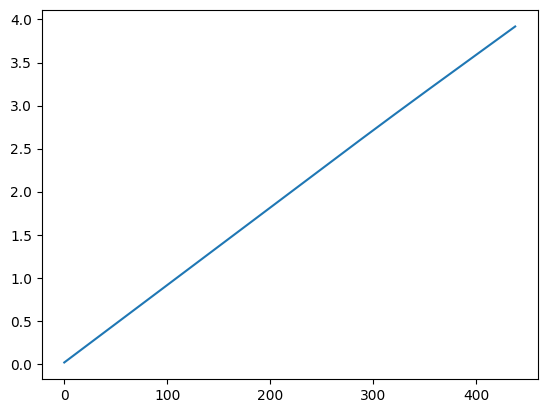

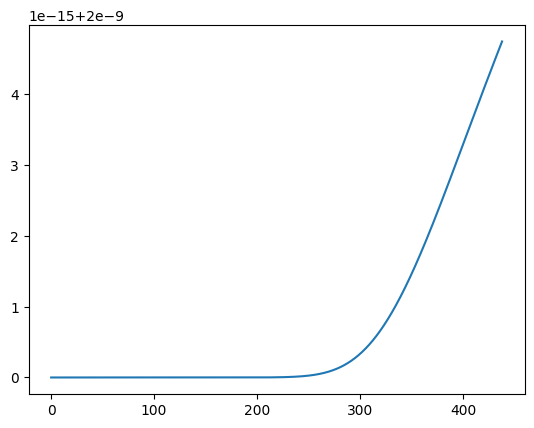

In [145]:
c = solution["concentration [mol.m-3]"].entries
L = solution["Thickness of SEI [m]"].entries
eta_int = solution["Overpotential [V]"].entries
vv = solution["Voltage [V]"].entries
u0 = solution["Opencircuit voltage [V]"].entries
Jint = solution["J_int"].entries


plt.plot(t, c)
plt.show()


plt.plot(t, L)
plt.show()


# plt.plot(t, eta_int)
# plt.show()


# plt.plot(t, vv)
# plt.show()

In [146]:
params["Initial thickness of SEI [m]"] = L[-1]
params["Current density [A.m-2]"] = 0.00001
params["Initial concentration [mol.m-3]"] = c[-1]

params = pybamm.ParameterValues(
    {'Lithium atom reference concentration [mol.m-3]': 1,  # Lar
     "alpha_SEI [-]": 0.22,  # Lars
     'Initial SEI reaction exchange current density [A.m-2]': 7.04e-5,  # Lars
     'Initial temperature [K]': 303,  # Lars standard temperature
     'Ideal gas constant [J.K-1.mol-1]': 8.314462618,  # Lar standard
     "Faraday constant [C.mol-1]": 96485,  # Lars standard
     "maximum lithium ion concentration in electrode [mol.m-3]": 3.16,  # Lars
     "Mean moler volume of SEI [m3.mol-1]": 1.078e-5,  # Lars
     "Lithium ion conductivity of the SEI [S.m-1]": 1e-8,
     # Lars was in KJ
     "Chemical reference potential of Li^0 [J.mol-1]": 17.4e+3,
     "Reference apparent thickness  [nm]": 0.05e-9,  # Lars
     "typical tunning distance  [nm]": 2.05e-9,  # Lars
     "Maximum Voltage during cycling [V]": 1.2,  # Lars
     "Minimum Voltage during cycling [V]": 0.01,    # Lars
     "Butler-Volmer rate constant for intercalation [A.m-2]": 6.4e-7,
     "Diffusion coefficient of Li atoms inside the SEI [m2.s-1]": 1e-15,
     "Surface area to volume ratio [m-1]": 86.8e+6,
     "Initial thickness of SEI [m]": L[-1],
     "open circuit voltage OCV [V]": OCP,
     # (2-40 mA h g-1) /Acb (0.000032 -0.00065)
     "Current density [A.m-2]": 0.00001,
     "Initial concentration [mol.m-3]": c[-1],
     }
)

model = pybamm.lithium_ion.BaseModel()


# eta_int = 2*R*T/F * pybamm.arcsinh((J_total-J_SEI) /
#                                    (2*j0_0 * pybamm.sqrt(cs/cs_max)))

J_int = 2*j0_0 * pybamm.sqrt(cs/cs_max) * pybamm.sinh(F/(2*R*T) * eta_int)
eta_bar_SEI = F/(R*T) * (eta_int + U0(cs/cs_max) + mu_Li_0/F)
L_diff = c_Li * D_Li * F / j_SEI_0_0 * pybamm.exp(-(1-alpha_SEI) * eta_bar_SEI)
L_mig = (2 * R * T * kappa_Li_SEI)/(F*pybamm.AbsoluteValue(J_int))
L_prime_app = L_SEI - L_tun
L_app = L_prime_app / 2 + ((L_prime_app/2)**10 + L_app_0**2)**(1/10)
J_SEI = - j_SEI_0_0 * pybamm.exp(-alpha_SEI * eta_bar_SEI) * \
    (1 + L_app/L_mig) / \
    (1 + L_app/L_mig + L_app/L_diff)

model.algebraic = {
    eta_int:  J_total - (J_int + J_SEI)
}

dcsdt = - A_cb*J_int/F
dL_SEIdt = - v_SEI * J_SEI / F


model.rhs = {cs: dcsdt, L_SEI: dL_SEIdt}

model.variables = {
    "concentration [mol.m-3]": cs,
    "Thickness of SEI [m]": L_SEI,
    "Overpotential [V]": eta_int,
    "Voltage [V]": -U0(cs/cs_max)+U1,
    "Opencircuit voltage [V]": U0(cs/cs_max),
    "J_int": J_int,

}


model.initial_conditions = {
    cs: cs_0,
    L_SEI: L_SEI_0,
    eta_int: U0(cs_0/cs_max)
}

params.process_model(model)
disc = pybamm.Discretisation()  # use the default discretisation
disc.process_model(model)

solver = pybamm.IDAKLUSolver()

tt = np.linspace(t[-1], 2*t[-1], 1000)

sim = pybamm.Simulation(
    model, parameter_values=params, solver=solver)

sol2 = sim.solve(tt)

NotImplementedError: BinaryOperator not implemented for symbols of type <class 'pybamm.expression_tree.binary_operators.Division'> and <class 'numpy.ndarray'>

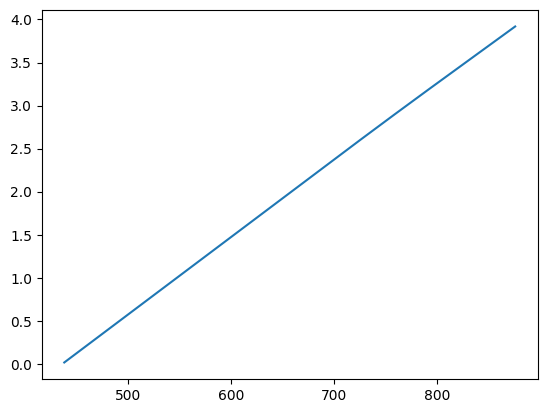

In [ ]:
cc = sol2["concentration [mol.m-3]"].entries
LL = sol2["Thickness of SEI [m]"].entries
plt.plot(tt, cc)
plt.show()